# Chargement et concaténation des données S3

In [ ]:
import pandas as pd
import os
import s3fs
from dotenv import load_dotenv

load_dotenv()

In [ ]:
BUCKET_NAME = "tristant"
S3_PREFIX = "diffusion"
S3_ENDPOINT = os.getenv("AWS_S3_ENDPOINT", "minio.lab.sspcloud.fr")
S3_URL = f"https://{S3_ENDPOINT}"

storage_options = {
    "client_kwargs": {"endpoint_url": S3_URL}
}

In [ ]:
FILES = [
    "dfs_games.parquet",
    "games_blitz.parquet",
    "games_rapid.parquet",
    "games_bullet.parquet",
    "games_classical.parquet",
]


In [ ]:
def read_all_games_without_listing():
    dfs = []

    for file in FILES:
        s3_path = f"s3://{BUCKET_NAME}/{S3_PREFIX}/{file}"
        format_partie = file.replace("games_", "").replace(".parquet", "")

        try:
            df = pd.read_parquet(s3_path, storage_options=storage_options)

            if file.startswith("games_"):
                df["format_partie"] = format_partie

            dfs.append(df)
            print(f"✅ Lu : {s3_path}")

        except Exception as e:
            print(f"❌ Erreur sur {s3_path} : {e}")

    game_dfs = [df for df in dfs if "format_partie" in df.columns]

    if game_dfs:
        df_total = pd.concat(game_dfs, ignore_index=True)
        print(f"\nImport terminé : {len(df_total)} parties")
        return df_total
    else:
        return pd.DataFrame()


In [ ]:
df_all = read_all_games_without_listing()
df_all.head()

In [ ]:
df_all["timestamp_ms"] = df_all["timestamp"]
df_all["date"] = pd.to_datetime(df_all["timestamp_ms"], unit="ms", utc=True)
df_all.head()

# Remise en forme du dataframe

In [ ]:
# 1️⃣ Trier par joueur et par temps
df_all = df_all.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

# 2️⃣ Créer la colonne binaire win
df_all["win"] = (df_all["result"] == "Win").astype(int)

# 3️⃣ Créer la colonne win_next par joueur
df_all["win_next"] = df_all.groupby("user_id")["win"].shift(-1)

# 4️⃣ Vérification rapide pour un joueur exemple
df_all[df_all["user_id"]=="alien_from_the_moon"][["timestamp","win","win_next"]]

On fait un shift(-1) car les parties les plus anciennes sont en haut du tableau. Un 1 en colonne Win_next veut dire que le joueur gagne la partie d'après (en comptant vers le bas).

In [ ]:
transition = (
    df_all.dropna(subset=["win_next"])
          .groupby("win")["win_next"]
          .agg(["mean", "count"])
)
print(transition)

In [ ]:
correlation = df_all[["win","win_next"]].dropna().corr().iloc[0,1]
print("Corrélation Win N → Win N+1 :", correlation)

In [ ]:
from scipy.stats import chi2_contingency

table = pd.crosstab(df_all["win"], df_all["win_next"])
chi2, p_value, _, _ = chi2_contingency(table)

print("p-value test χ² :", p_value)

Analyse par format de parties

In [ ]:
df_all.groupby("format_partie").apply(
    lambda x: x.groupby("win")["win_next"].mean()
)

Analyse par tranche de rating

In [56]:
df_all["rating_bin"] = pd.cut(df_all["rating"], bins=[0,2000,2200,2400,2600,3000])
df_all.groupby("rating_bin").apply(lambda x: x.groupby("win")["win_next"].mean())

/tmp/ipykernel_14304/4004785903.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all.groupby("rating_bin").apply(lambda x: x.groupby("win")["win_next"].mean())
/tmp/ipykernel_14304/4004785903.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all.groupby("rating_bin").apply(lambda x: x.groupby("win")["win_next"].mean())


win,0,1
rating_bin,,
"(0, 2000]",0.631579,0.837838
"(2000, 2200]",0.696078,0.705128
"(2200, 2400]",0.652778,0.684160
"(2400, 2600]",0.534170,0.592077
"(2600, 3000]",0.540741,0.641703


Analyse par joueur

In [57]:
df_all.groupby("user_id").apply(lambda x: x["win"].shift(-1).corr(x["win"]))

/tmp/ipykernel_14304/30971620.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all.groupby("user_id").apply(lambda x: x["win"].shift(-1).corr(x["win"]))


user_id
alien_from_the_moon   -0.054965
amolmav               -0.013581
angelitort             0.076141
arm-777777             0.344553
art-vega              -0.086910
                         ...   
tommy_pug              0.202055
tsoi_dima             -0.098220
viti77                 0.147412
winx_m                 0.001422
zlatoustintergaming    0.095238
Length: 79, dtype: float64

Visualisation graphique :

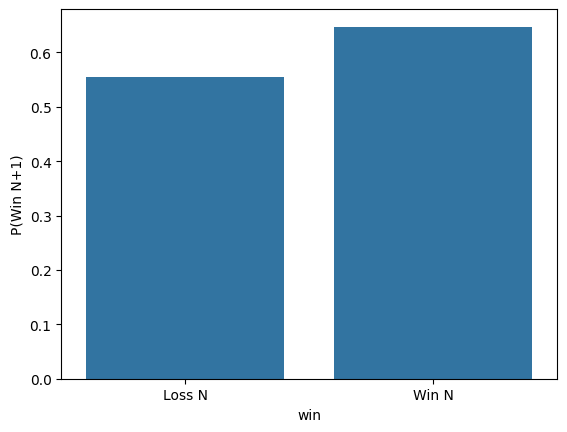

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=transition.index, y=transition["mean"])
plt.xticks([0,1], ["Loss N","Win N"])
plt.ylabel("P(Win N+1)")
plt.show()